**Important! Please do not remove any cells, including the test cells, even if they appear empty. They contain hidden tests, and deleting them could result in a loss of points, as the exercises are graded automatically. Only edit the cells where you are instructed to write your solution.**

# Exercise 3

## Task 3: Optimization Practices (5 Points)

In this task, you will practice optimization techniques by experimenting with different optimizers, learning rates, and batch sizes. The main objectives include observing the performance and computational costs related to training time. Additionally, pay attention to the training curves: in deep learning, smoother training and validation curves are generally desirable, as they often indicate stable learning and consistent generalization.

You can achieve smoother training curves by adjusting the learning rate and increasing the batch size. Another important factor to consider is batch variability through data shuffling. While data shuffling can enhance training, very high learning rates, combined with shuffling, can negatively impact the smoothness and stability of the training process, potentially leading to unstable learning.

By completing this task, you will gain insights into how different optimization choices affect the training dynamics of your model.


### Summary of Tasks for This Stage


**Task 3.1: Experiment with Adam optimizer with different learning rates** (1 point)

    Goal: Increase the learning rate in each test to find the optimal learning rate.

**Task 3.2: Experiment with Adam optimizer with different learning rates and shuffling data in each batch** (1 point)

    Goal: Allow the data to be shuffled in each batch, increase the learning rate, and observe its effect.

**Task 3.3: Experiment with Adam optimizer and different batch sizes** (1 point)

    Goal: Observe the effect of batch sizes on training stability and efficiency.

**Task 3.4: Experiment with SGD optimizer with different learning rates and shuffling data in each batch** (1 point)

    Goal: Observe the effect of data variability and learning rate in the SGD optimizer.

**Task 3.5: Experiment with SGD optimizer and batch normalization layers** (1 point)

    Goal: Observe the effect of batch normalization layers in the SGD optimizer.
    

### Deliverables from this task:

* ex3_03_optimization.ipynb
* 'lr_model.pth'
* 'shuffle_model.pth'
* 'bs_model.pth'
* 'SGD_model.pth'


In [1]:
skip_training = False   # You can set it to True if you want to run inference on your trained model. 

In [ ]:
# Do not delete this cell

In [2]:
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import random

# Set random seeds for all libraries
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1) 

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Add the data path

In [4]:
path = "dataset_ex3" # you can change the path if you want to store the dataset somewhere else.

In [ ]:
# Do not delete this cell

In [5]:
def prepare_file_list(path, validation_split):
    
    audio_class_names = ['music', 'speech']
    data_directories = {'music': path + '/music_wav', 
                        'speech': path + '/speech_wav'}
    
    audio_files = {class_name: [] for class_name in audio_class_names}
    for class_name in audio_class_names:
        folder = data_directories[class_name]
        filelist = os.listdir(folder)
        for filename in filelist:
            if filename.endswith('.wav'):
                audio_files[class_name].append(os.path.join(folder, filename))
       
    np.random.seed(1)
    dataset_split = {'train': [], 'val': []}
    for class_id, class_name in enumerate(audio_class_names):
        n_data = len(audio_files[class_name])
        random_indices = np.random.permutation(n_data)
        n_validation = int(validation_split * n_data)
        val_indices = random_indices[:n_validation]
        train_indices = random_indices[n_validation:]
        dataset_split['train'] += [(audio_files[class_name][k], class_id) for k in train_indices] 
        dataset_split['val'] += [(audio_files[class_name][k], class_id) for k in val_indices] 
    return dataset_split

In [6]:
class MSDataset(torch.utils.data.Dataset):
    
    def __init__(self, filelist, sample_sec=5., is_train=True):
        self.filelist = filelist
        self.time_duration = sample_sec
        self.is_train = is_train
        
        _, sf = librosa.load(filelist[0][0], sr = None)
        self.sf = sf
        self.n_features = int(self.time_duration * sf)
        
    def __len__(self):
        return len(self.filelist)
    
    def __getitem__(self, i):
        audio_file, class_id = self.filelist[i]
        x, sf = librosa.load(audio_file, sr = None)
        k = 0
            
        x = torch.from_numpy(x[k:k+self.n_features]).reshape(1,-1)
        
        return x, class_id

### Model Architecture: 

Fill in the blanks as instructed in the code to design the model architecture as in the base model.

**Hint:** Replace the next cell with the base model from the task 1. 

In [7]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, nonlin="Tanh"):
        super().__init__()
        self.conv_layer = nn.Conv1d(in_channels=in_channels,
                                    out_channels=out_channels,
                                    kernel_size=11,
                                    stride=5)
        if nonlin == "ELU":
            self.activation_fn = nn.ELU()
        elif nonlin == "ReLU":
            self.activation_fn = nn.ReLU()
        elif nonlin == "Tanh":
            self.activation_fn = nn.Tanh()

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.activation_fn(x)
        return x

class MyModel(nn.Module):
    def __init__(self, nonlin ="Tanh"):
        super().__init__()
        
        # your code here for initializing layers
        # 1. Create the first hidden layer using BasicBlock
        #    - Input channels: 1 
        #    - Output channels: 32
        #    - Activation function: specified by 'nonlin'
        # 2. Create the second hidden layer using BasicBlock
        #    - Activation function: specified by 'nonlin'
        # 3. Create the third hidden layer using BasicBlock
        #    - Input channels: 32 (from the output of the second layer)
        #    - Output channels: 2 (for the final output classes)
        #    - Activation function: specified by 'nonlin'
        # 4. Create a global average pooling layer to reduce the spatial dimensions
        # 5. Create a flattening layer to flatten the output for the final layer
        # 6. Set the output activation function for classification

        self.hidden1 = BasicBlock(1, 32, nonlin)
        self.hidden2 = BasicBlock(32, 32, nonlin)
        self.hidden3 = BasicBlock(32, 2, nonlin)
        self.average_pooling = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        # your code here for calling layers
        # 1. Pass the input through the first hidden layer
        # 2. Pass the output to the second hidden layer
        # 3. Pass the output to the third hidden layer
        # 4. Apply global average pooling to reduce dimensions
        # 5. Flatten the pooled output
        # 6. Apply the output activation function to get the final predictions
        
        x = self.hidden1.forward(x)
        x = self.hidden2.forward(x)
        x = self.hidden3.forward(x)
        x = self.average_pooling(x)
        x = self.flatten(x)
        x = self.logsoftmax(x)
        
        return x

def get_num_trainable_parameters(model):
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model has {num_params} trainable parameters.')
    return num_params

### Training and validation loops: 

Fill in the blanks as instructed in the code.

**Hint:** Replace the next cell with the training and validation loops from your solution to Task 1 in the ex3_01_base_model.ipynb file.

In [8]:
def training_loop(n_epochs, optim, model, loss_fn, dl_train, dl_val, hist=None):
    np.random.seed(1)
    if hist is not None:
        pass
    else:
        hist = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}
    
    best_accuracy = 0
    t_initial = time.time()
    
    for epoch in range(1, n_epochs + 1):
        start = time.time()
        train_loss, train_accuracy = 0., 0.
        num_samples = 0
        
        for input_batch, target_batch in dl_train: 
            # your code here for minibatch training
            # 1. call batch data and labels and set them to the correct device
            # 2. make the prediction on the data
            # 3. calculate loss
            # 4. set optimizer to zero grad
            # 5. do backward pass
            # 6. move the optimizer one step forward

            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            predictions = model(input_batch)
            loss_train = loss_fn(predictions, target_batch)

            optim.zero_grad()
            loss_train.backward()
            optim.step()
            
            # accumulate correct prediction
            train_accuracy += (torch.argmax(predictions.detach(), dim=1) == target_batch).sum().item() # number of correct predictions
            train_loss += loss_train.item() * input_batch.shape[0]
            num_samples += input_batch.shape[0]
        
        train_loss /= num_samples
        train_accuracy /= num_samples       
        val_loss, val_accuracy = validation_loop(model, loss_fn, dl_val)
        
        end = time.time()
        epoch_time = round(end - start, 2)
        if epoch <= 5 or epoch % 10 == 0 or epoch == n_epochs:
             print(f'Epoch {epoch}, train_loss {train_loss:.2f}, train_accuracy: {train_accuracy:.4f}, '
                   f'val_loss {val_loss:.2f}, val_accuracy: {val_accuracy:.4f}, time = {epoch_time}')

        # record for history return
        hist['train_loss'].append(train_loss)
        hist['val_loss'].append(val_loss) 
        hist['train_accuracy'].append(train_accuracy)
        hist['val_accuracy'].append(val_accuracy)
        
    t_final = time.time()
    t_total = round(t_final - t_initial, 2)
    minutes = int(t_total // 60)
    seconds = int(t_total % 60)
    print(f'Finished training_loop() within {minutes} minutes and {seconds} seconds')
    return hist

def validation_loop(model, loss_fn, dataloader):
    model.eval()
    with torch.no_grad():
        total_loss, total_accuracy, num_samples = 0., 0., 0.
        
        for input_batch, target_batch in dataloader:
            # your code here for minibatch validation
            # 1. set input_batch, target_batch to correct device
            # 2. make the prediction on input_batch
            # 3. calculate loss and add it to previous loss
            # 4. obtain predicted class labels from predictions (hint: use torch.argmax)

            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            predictions = model(input_batch)

            loss = loss_fn(predictions, target_batch)

            total_loss += loss.item() * input_batch.shape[0]

            predicted_classes = torch.argmax(predictions.detach(), dim=1)

            ###
            
            total_accuracy += (predicted_classes == target_batch).sum().item()
            num_samples += len(target_batch)
    
    average_loss = total_loss / num_samples
    average_accuracy = total_accuracy / num_samples
    
    return average_loss, average_accuracy

def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    axes[0].set_title('Loss')
    axes[0].plot(history['train_loss'], label='Train')
    axes[0].plot(history['val_loss'], label='Validation')
    axes[0].legend()

    max_val_accuracy = max(history['val_accuracy'])
    axes[1].set_title(f'Accuracy (Best: {max_val_accuracy:.2f})')
    axes[1].plot(history['train_accuracy'], label='Train')
    axes[1].plot(history['val_accuracy'], label='Validation')
    axes[1].legend()

### Task 3.1: Experiment with Adam optimizer with different learning rates

Use the settings applied in Task 1 for the base model:

- `batch_size = 8`
- `optimizer = "Adam"`

Gradually increase the learning rate from 0.0001 (used in the base model) to observe its effect and find the optimal learning rate for this setting. In particular, test the following learning rates:

- `lr = [0.0001, 0.001, 0.01, 0.1]`

Save the best-performing model as **'lr_model.pth'** and submit it to Moodle along with your other files.

**Goal**: Identify how different learning rates impact model performance, stability, and training efficiency for the current setup.



In [9]:
# data
np.random.seed(1)  
valsplit = 0.30
file_list =  prepare_file_list(path, valsplit)  
sample_sec = 2
batch_size = 8
data_loader = {tv: torch.utils.data.DataLoader(MSDataset(file_list[tv], sample_sec=sample_sec, is_train=tv=='train'),
                                               batch_size=batch_size,
                                               shuffle=False) for tv in ['train', 'val']}

# loss
criterion = nn.CrossEntropyLoss().to(device)


Epoch 1, train_loss 0.95, train_accuracy: 0.2333, val_loss 0.69, val_accuracy: 0.4737, time = 0.62
Epoch 2, train_loss 0.71, train_accuracy: 0.4889, val_loss 0.69, val_accuracy: 0.5000, time = 0.57
Epoch 3, train_loss 0.69, train_accuracy: 0.4667, val_loss 0.69, val_accuracy: 0.3947, time = 0.65
Epoch 4, train_loss 0.69, train_accuracy: 0.4778, val_loss 0.69, val_accuracy: 0.4474, time = 0.73
Epoch 5, train_loss 0.69, train_accuracy: 0.5333, val_loss 0.69, val_accuracy: 0.4211, time = 0.61
Epoch 10, train_loss 0.92, train_accuracy: 0.3222, val_loss 0.71, val_accuracy: 0.3684, time = 0.56
Epoch 20, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5526, time = 0.72
Epoch 30, train_loss 0.67, train_accuracy: 0.5000, val_loss 0.68, val_accuracy: 0.5000, time = 0.68
Epoch 40, train_loss 0.66, train_accuracy: 0.4889, val_loss 0.68, val_accuracy: 0.4737, time = 0.56
Epoch 50, train_loss 0.66, train_accuracy: 0.5000, val_loss 0.67, val_accuracy: 0.5263, time = 0.58
Epoch

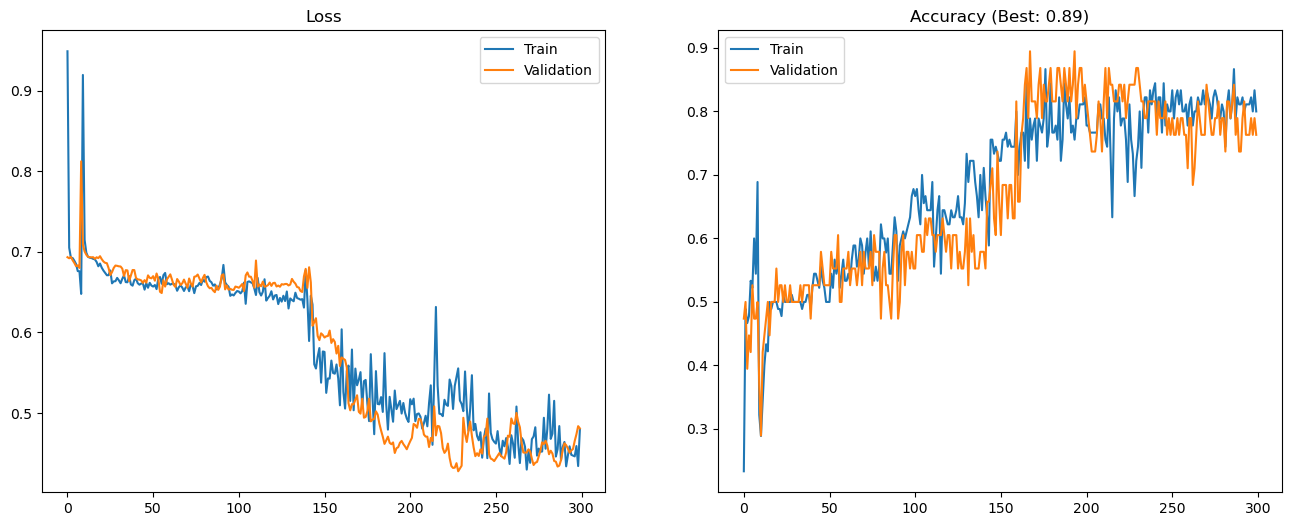

In [13]:
# model
model = MyModel("Tanh").to(device)

# optimizer
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# history
history = None
if not skip_training:
    history = training_loop(300, optimizer, model, criterion, data_loader['train'], data_loader['val'], history)
    torch.save(model.state_dict(), 'lr_model.pth')
    plot_history(history)

In [ ]:
# Do not delete this cell

### Task 3.2: Experiment with Adam optimizer with different learning rates and shuffling data in each batch 

Repeat the experiments from Task 3.1, this time with data shuffling enabled to increase batch variability (by setting `shuffle=True`). Test the following learning rates:

- `lr = [0.0001, 0.001, 0.01, 0.1]`

Save the best-performing model as **'shuffle_model.pth'** and submit it to Moodle along with your other files.

**Goal**: Identify how different learning rates impact model performance and stability in the presence of data variability.

In [14]:
# data
np.random.seed(1)  
valsplit = 0.30
file_list =  prepare_file_list(path, valsplit)  
sample_sec = 2
batch_size = 8
data_loader = {tv: torch.utils.data.DataLoader(MSDataset(file_list[tv], sample_sec=sample_sec, is_train=tv=='train'),
                                               batch_size=batch_size,
                                               shuffle=True) for tv in ['train', 'val']}

# loss
criterion = nn.CrossEntropyLoss().to(device)


Epoch 1, train_loss 0.77, train_accuracy: 0.5222, val_loss 0.69, val_accuracy: 0.5000, time = 0.63
Epoch 2, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5263, time = 0.63
Epoch 3, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.68, val_accuracy: 0.5000, time = 0.66
Epoch 4, train_loss 0.73, train_accuracy: 0.5000, val_loss 0.86, val_accuracy: 0.5000, time = 0.79
Epoch 5, train_loss 0.71, train_accuracy: 0.5000, val_loss 0.68, val_accuracy: 0.5000, time = 0.64
Epoch 10, train_loss 0.65, train_accuracy: 0.5000, val_loss 0.67, val_accuracy: 0.5000, time = 0.69
Epoch 20, train_loss 0.64, train_accuracy: 0.5000, val_loss 0.66, val_accuracy: 0.5000, time = 0.63
Epoch 30, train_loss 0.64, train_accuracy: 0.5333, val_loss 0.66, val_accuracy: 0.5000, time = 0.69
Epoch 40, train_loss 0.64, train_accuracy: 0.6111, val_loss 0.66, val_accuracy: 0.5263, time = 0.57
Epoch 50, train_loss 0.63, train_accuracy: 0.6333, val_loss 0.65, val_accuracy: 0.5789, time = 0.6
Epoch 

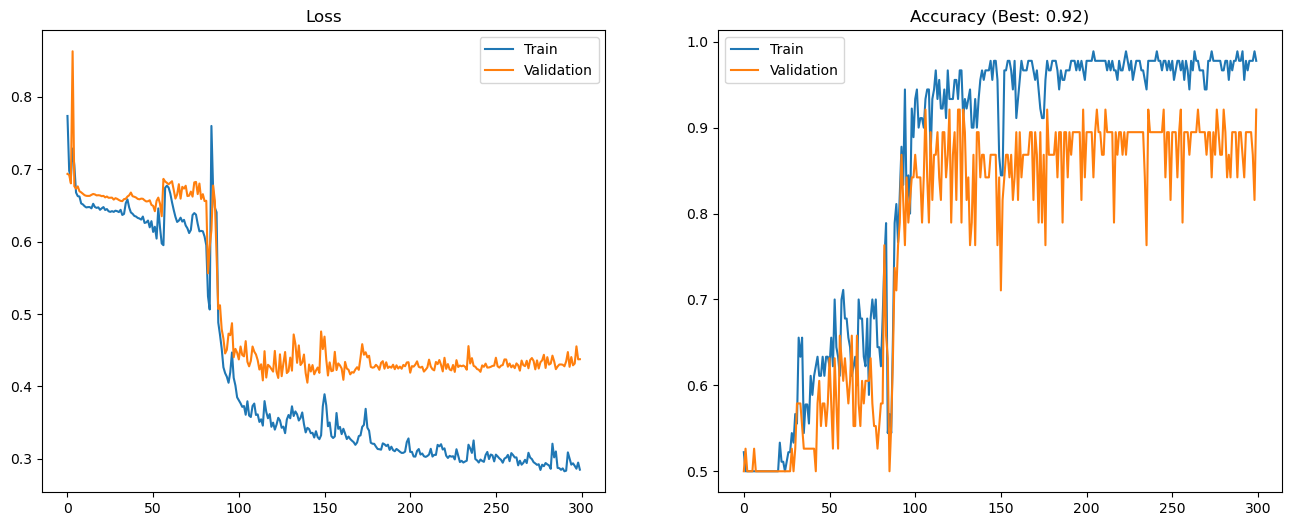

In [19]:
# model
model = MyModel("Tanh").to(device)

# optimizer
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# history
history = None
if not skip_training:
    history = training_loop(300, optimizer, model, criterion, data_loader['train'], data_loader['val'], history)
    torch.save(model.state_dict(), 'shuffle_model.pth')
    plot_history(history)

In [ ]:
# Do not delete this cell

### Task 3.3: Experiment with Adam optimizer and different batch sizes

Now, set the optimizer to Adam with `lr = 0.001` and disable data shuffling (`shuffle=False`). Try different batch sizes as specified below:

- `bs = [4, 8, 16, 32]`

Save the best-performing model as **'bs_model.pth'** and submit it to Moodle along with your other files.

**Optional:** You may repeat the experiments above with data shuffling enabled (`shuffle=True`) to observe the impact of batch size when data variability is increased.

In [15]:

batch_size = 8


Epoch 1, train_loss 1.04, train_accuracy: 0.5000, val_loss 0.79, val_accuracy: 0.5000, time = 0.64
Epoch 2, train_loss 0.68, train_accuracy: 0.5000, val_loss 0.70, val_accuracy: 0.5000, time = 0.69
Epoch 3, train_loss 0.73, train_accuracy: 0.5000, val_loss 0.71, val_accuracy: 0.5000, time = 0.73
Epoch 4, train_loss 0.75, train_accuracy: 0.5000, val_loss 0.70, val_accuracy: 0.5000, time = 0.63
Epoch 5, train_loss 0.73, train_accuracy: 0.5000, val_loss 0.70, val_accuracy: 0.5000, time = 0.6
Epoch 10, train_loss 0.71, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 0.59
Epoch 20, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 0.58
Epoch 30, train_loss 0.68, train_accuracy: 0.5111, val_loss 0.68, val_accuracy: 0.5263, time = 0.54
Epoch 40, train_loss 0.65, train_accuracy: 0.5333, val_loss 0.67, val_accuracy: 0.6053, time = 0.57
Epoch 50, train_loss 0.62, train_accuracy: 0.7111, val_loss 0.67, val_accuracy: 0.5789, time = 0.71
Epoch 

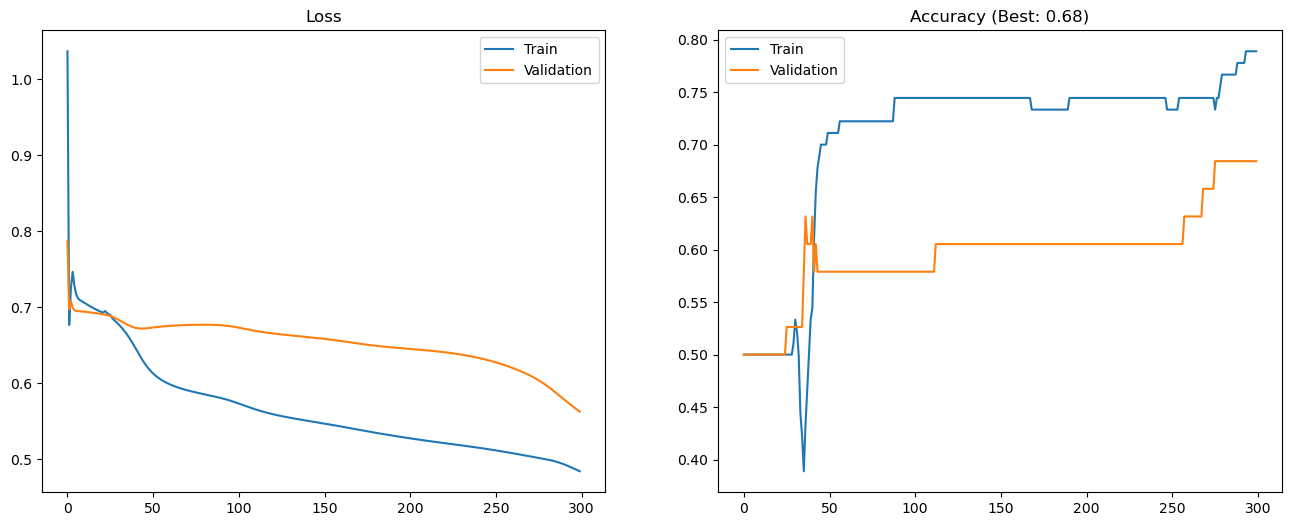

In [16]:
# data
np.random.seed(1)  
valsplit = 0.30
file_list =  prepare_file_list(path, valsplit)  
sample_sec = 2

data_loader = {tv: torch.utils.data.DataLoader(MSDataset(file_list[tv], sample_sec=sample_sec, is_train=tv=='train'),
                                               batch_size=batch_size,
                                               shuffle=False) for tv in ['train', 'val']}
# model
model = MyModel("Tanh").to(device)

# loss
criterion = nn.CrossEntropyLoss().to(device)

# optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# history
history = None
if not skip_training:
    history = training_loop(300, optimizer, model, criterion, data_loader['train'], data_loader['val'], history)
    torch.save(model.state_dict(), 'bs_model8.pth')
    plot_history(history) 

In [ ]:
# Do not delete this cell

### Task 3.4: Experiment with SGD optimizer with different learning rates and shuffling data in each batch

Repeat the experiments from Task 3.2, keeping data shuffling enabled, and change the optimizer to SGD. Test the following learning rates:

- `lr = [0.0001, 0.001, 0.01, 0.1]`

Save the best-performing model as **'SGD_model.pth'** and submit it to Moodle along with your other files.

**Goal**: Observe the different behaviors of Adam and SGD optimizers, and examine how the choice of optimizer impacts the selection and effect of learning rate on model performance.

In [17]:
# data
np.random.seed(1)  
valsplit = 0.30
file_list =  prepare_file_list(path, valsplit)  
sample_sec = 2
batch_size = 8
data_loader = {tv: torch.utils.data.DataLoader(MSDataset(file_list[tv], sample_sec=sample_sec, is_train=tv=='train'),
                                               batch_size=batch_size,
                                               shuffle=True) for tv in ['train', 'val']}

# loss
criterion = nn.CrossEntropyLoss().to(device)

Epoch 1, train_loss 0.71, train_accuracy: 0.4111, val_loss 0.69, val_accuracy: 0.5000, time = 0.61
Epoch 2, train_loss 0.70, train_accuracy: 0.4778, val_loss 0.69, val_accuracy: 0.5000, time = 0.56
Epoch 3, train_loss 0.70, train_accuracy: 0.4333, val_loss 0.69, val_accuracy: 0.5000, time = 0.57
Epoch 4, train_loss 0.70, train_accuracy: 0.4778, val_loss 0.69, val_accuracy: 0.5526, time = 0.57
Epoch 5, train_loss 0.70, train_accuracy: 0.4667, val_loss 0.69, val_accuracy: 0.5000, time = 0.58
Epoch 10, train_loss 0.70, train_accuracy: 0.4556, val_loss 0.69, val_accuracy: 0.5000, time = 0.57
Epoch 20, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 0.55
Epoch 30, train_loss 0.69, train_accuracy: 0.4556, val_loss 0.69, val_accuracy: 0.5000, time = 0.55
Epoch 40, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.70, val_accuracy: 0.5000, time = 0.54
Epoch 50, train_loss 0.70, train_accuracy: 0.4556, val_loss 0.69, val_accuracy: 0.5000, time = 0.55
Epoch

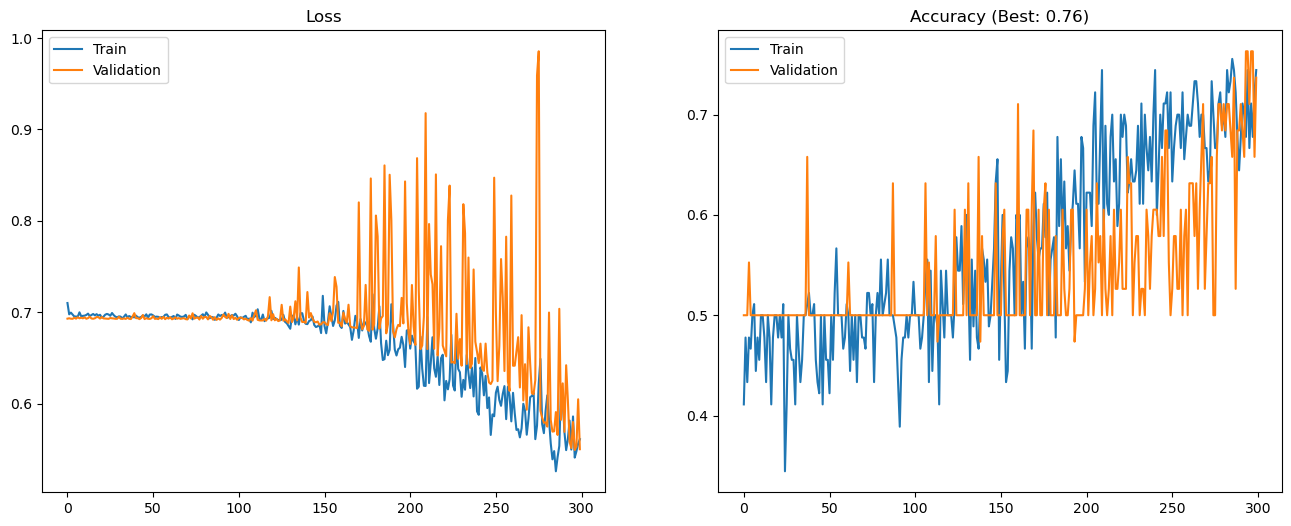

In [21]:
# model
model = MyModel("Tanh").to(device)

# optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# history
history = None
if not skip_training:
    history = training_loop(300, optimizer, model, criterion, data_loader['train'], data_loader['val'], history)
    torch.save(model.state_dict(), 'SGD_model4.pth')
    plot_history(history) 

In [ ]:
# Do not delete this cell

### Task 3.5: Experiment with SGD optimizer and normalization layers

Next, test the effect of batch normalization layers on the SGD optimizer using the following setup for training:

- Batch data shuffling disabled (`shuffle=False`)
- `lr = 0.01`
- `bs = 16`

Use the base model, then add a batch normalization layer within each convolutional block. Place this layer directly after each convolution layer and before applying the non-linearity function, as indicated in the code.

**useful link**: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html

In [22]:
class BasicBlock(nn.Module):
    # your code here the convolutional block. Use the base model, 
    # add one batch normalization layer after convolution layer and before non-linearity function   
    def __init__(self, in_channels, out_channels, nonlin="Tanh"):
        super().__init__()
        self.conv_layer = nn.Conv1d(in_channels=in_channels,
                                    out_channels=out_channels,
                                    kernel_size=11,
                                    stride=5)
        self.batch_norm = nn.BatchNorm1d(out_channels)

        if nonlin == "ELU":
            self.activation_fn = nn.ELU()
        elif nonlin == "ReLU":
            self.activation_fn = nn.ReLU()
        elif nonlin == "Tanh":
            self.activation_fn = nn.Tanh()

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.batch_norm(x)
        x = self.activation_fn(x)
        return x

class MyModel(nn.Module):
    def __init__(self, nonlin ="Tanh"):
        super().__init__()
        
        # your code here for initializing layers
        # 1. Create the first hidden layer using BasicBlock
        #    - Input channels: 1 
        #    - Output channels: 32
        #    - Activation function: specified by 'nonlin'
        # 2. Create the second hidden layer using BasicBlock
        #    - Activation function: specified by 'nonlin'
        # 3. Create the third hidden layer using BasicBlock
        #    - Input channels: 32 (from the output of the second layer)
        #    - Output channels: 2 (for the final output classes)
        #    - Activation function: specified by 'nonlin'
        # 4. Create a global average pooling layer to reduce the spatial dimensions
        # 5. Create a flattening layer to flatten the output for the final layer
        # 6. Set the output activation function for classification

        self.hidden1 = BasicBlock(1, 32, nonlin)
        self.hidden2 = BasicBlock(32, 32, nonlin)
        self.hidden3 = BasicBlock(32, 2, nonlin)
        self.average_pooling = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.logsoftmax = nn.LogSoftmax(dim=1) 
       
    def forward(self, x):
        # your code here for calling layers
        # 1. Pass the input through the first hidden layer
        # 2. Pass the output to the second hidden layer
        # 3. Pass the output to the third hidden layer
        # 4. Apply global average pooling to reduce dimensions
        # 5. Flatten the pooled output
        # 6. Apply the output activation function to get the final predictions
        
        x = self.hidden1.forward(x)
        x = self.hidden2.forward(x)
        x = self.hidden3.forward(x)
        x = self.average_pooling(x)
        x = self.flatten(x)
        x = self.logsoftmax(x)
        
        return x

def get_num_trainable_parameters(model):
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model has {num_params} trainable parameters.')
    return num_params

Run the cell below to verify the correctness of your solution for the model architecture.

In [23]:
# Visible tests here
all_tests_successful = True
model = MyModel("Tanh")
dummy_input = torch.randn(1, 1, 22000)

# Dictionary to hold the execution order of each BasicBlock's layers
layer_execution_order = {}
# Function to capture forward pass order of layers within each BasicBlock
def track_execution_order(module, input, output, name):
    layer_types = []
    for sub_module in module.children():  # Iterate through layers within BasicBlock
        layer_types.append(type(sub_module))
    layer_execution_order[name] = layer_types

# Register hooks on each BasicBlock to capture layer order in forward pass
for name, module in model.named_modules():
    if isinstance(module, BasicBlock):
        module.register_forward_hook(lambda mod, inp, out, n=name: track_execution_order(mod, inp, out, n))

# Run the model forward pass to trigger hooks
dummy_output = model(dummy_input)

# Define the expected order of layer types for BasicBlock
expected_order = [nn.Conv1d, nn.BatchNorm1d, nn.Tanh]  

# Check if each BasicBlock followed the expected order
for name, order in layer_execution_order.items():
    # Modify expected_order based on the chosen activation in model
    current_expected_order = expected_order[:]
    activation_fn_type = type(model.Hidden_1.activation_fn)  # Get the actual activation type
    current_expected_order[-1] = activation_fn_type
    
    if order != current_expected_order:
        all_tests_successful = False
        raise AssertionError(
            f"{name} layer order incorrect. Expected {[cls.__name__ for cls in current_expected_order]} "
            f"but got {[cls.__name__ for cls in order]}."
        )

# Check output shape and range for LogSoftmax
expected_shape = (1, 2)
if dummy_output.shape != expected_shape:
    all_tests_successful = False
    raise AssertionError(f"Expected output shape {expected_shape}, got {dummy_output.shape}.")
if not torch.all(dummy_output <= 0):
    all_tests_successful = False
    raise AssertionError("The output values are not within the expected range (-∞, 0]. LogSoftmax might be missing.")

# Final success message if all tests pass
if all_tests_successful:
    success_str = "Good job! All visible tests passed! You can proceed further."
    print(f"\033[92m{success_str}\033[0m")

Good job! All visible tests passed! You can proceed further.


### Train and Validate

Now, run the cell below to apply training and validation for the model with the batch normalization layer using the SGD optimizer with a learning rate of 0.01.

Compare the performance and stability of the training and validation curves with the settings from Task 3.3 to observe the effect of the batch normalization layer on the SGD optimizer.

Epoch 1, train_loss 0.70, train_accuracy: 0.4000, val_loss 0.69, val_accuracy: 0.5000, time = 0.62
Epoch 2, train_loss 0.83, train_accuracy: 0.5000, val_loss 0.70, val_accuracy: 0.5000, time = 0.6
Epoch 3, train_loss 0.67, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 0.6
Epoch 4, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.70, val_accuracy: 0.5000, time = 0.61
Epoch 5, train_loss 0.72, train_accuracy: 0.5000, val_loss 0.70, val_accuracy: 0.5000, time = 0.61
Epoch 10, train_loss 0.71, train_accuracy: 0.5000, val_loss 0.70, val_accuracy: 0.5000, time = 0.6
Epoch 20, train_loss 0.71, train_accuracy: 0.5000, val_loss 0.70, val_accuracy: 0.5000, time = 0.62
Epoch 30, train_loss 0.71, train_accuracy: 0.5000, val_loss 0.70, val_accuracy: 0.5000, time = 0.6
Epoch 40, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.70, val_accuracy: 0.5000, time = 0.6
Epoch 50, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.70, val_accuracy: 0.5000, time = 0.59
Epoch 60, 

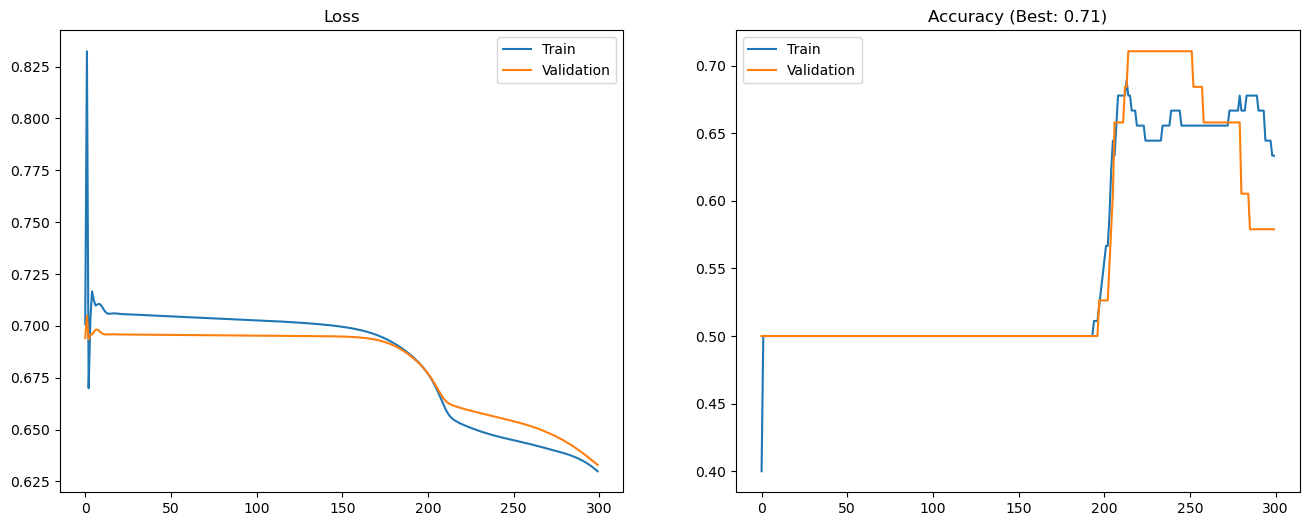

In [24]:
# data
np.random.seed(1)  
valsplit = 0.30
file_list =  prepare_file_list(path, valsplit)  
sample_sec = 2
batch_size = 16
data_loader = {tv: torch.utils.data.DataLoader(MSDataset(file_list[tv], sample_sec=sample_sec, is_train=tv=='train'),
                                               batch_size=batch_size,
                                               shuffle=False) for tv in ['train', 'val']}

# model
model = MyModel("Tanh").to(device)

# optim
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9)

# loss
criterion = nn.CrossEntropyLoss().to(device)

# history
history = None
if not skip_training:
    history = training_loop(300, optimizer, model, criterion, data_loader['train'], data_loader['val'], history)
    torch.save(model.state_dict(), 'model.pth')
    plot_history(history)   